In [1]:
#Import different packages
import requests,os,time
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from tqdm import tqdm_notebook as tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as scores
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

In [2]:
url = 'https://github.com/mathiasbruun/SDS19-Exam-Project/raw/master/Data_with_mean_income_population.zip'
Data = pd.read_csv(url, compression='zip', na_values='NaN', low_memory=False)

In [3]:
#Plot settings
plt.style.use('ggplot')
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
Data.columns

Index(['age_range', 'datetime', 'gender', 'involved_person', 'legislation',
       'object_of_search', 'officer_defined_ethnicity', 'operation',
       'operation_name', 'outcome', 'outcome_linked_to_object_of_search',
       'removal_of_more_than_outer_clothing', 'self_defined_ethnicity', 'type',
       'Force', 'latitude', 'street_name', 'street_id', 'longitude',
       'outcome_object_id', 'outcome_object_name', 'nearest_local_auth',
       'month', 'hour', 'Night_dummy', 'mean_income', 'mean_population'],
      dtype='object')

In [5]:
#Create dataframe with relevant variables
Df = Data.copy()
Df.set_index('datetime', drop = True, inplace=True)
#Define succes variable
Df['succes'] = ~Df.loc[:,'outcome'].isin(['A no further action disposal', 'False'])
#Slice features for model
Df = Df.loc[:,['age_range', 'gender', 'object_of_search', 'officer_defined_ethnicity', 
               'type', 'succes','Force','hour', 'month']]
#Make month and hour string so they can be converted to dummy variables
Df['month'] = Df['month'].astype(str)
Df['hour'] = Df['hour'].astype(str)
Df = Df.dropna()
Df.head(3)

,age_range,gender,object_of_search,officer_defined_ethnicity,type,succes,Force,hour,month
datetime,,,,,,,,,
2016-07-01 03:36:40+00:00,18-24,Female,Controlled drugs,White,Person search,True,avon-and-somerset,3,7
2016-07-01 03:36:40+00:00,18-24,Female,Controlled drugs,White,Person search,False,avon-and-somerset,3,7
2016-07-01 03:36:40+00:00,18-24,Female,Controlled drugs,White,Person search,False,avon-and-somerset,3,7


In [6]:
print(len(Df))
Variables = pd.DataFrame(Df.columns, columns=['Variables']).drop(5, axis=0)
Variables = Variables.reset_index(drop=True)
Variables

673651


,Variables
0,age_range
1,gender
2,object_of_search
3,officer_defined_ethnicity
4,type
5,Force
6,hour
7,month


In [7]:
#Create dummies -> mean_income and mean_population will not be converted
Df = pd.get_dummies(Df, drop_first=True)
Df['succes'] = Df['succes'].astype(int)
X = Df.drop('succes', axis = 1)
y = Df['succes']

In [8]:
#Check the mean outcome of the stops and searches
y.describe()
1-y.mean()

0.677785678340862

In [9]:
# split into development and test data
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))

#Define lambdas
lambdas = np.logspace(-2, 2, 5)

# outer loop: lambdas
Accuracy = []

for lambda_ in tqdm(lambdas):    
    # inner loop: folds
    Accuracy_i = [] 
    for train_idx, val_idx in folds:        
        # train model and compute accuracy on test fold
        logr = make_pipeline(StandardScaler(), LogisticRegression(solver = 'lbfgs', C=lambda_, random_state=1, max_iter=200))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev[val_idx] 
        logr.fit(X_train, y_train)        
        Accuracy_i.append(logr.score(X_val, y_val))      
        
    # store result    
    Accuracy.append(Accuracy_i)

    
# convert to DataFrame
lambdaCV = pd.DataFrame(Accuracy, index=lambdas)
lambdaCV

,0,1,2,3,4,5,6,7,8,9
0.01,0.679544,0.678431,0.679915,0.680862,0.680453,0.680175,0.679711,0.678895,0.680583,0.679155
0.10,0.679656,0.678394,0.679897,0.680862,0.680435,0.680157,0.679730,0.678932,0.680528,0.679117
1.00,0.679656,0.678394,0.679897,0.680862,0.680435,0.680157,0.679730,0.678932,0.680528,0.679117
10.00,0.679656,0.678394,0.679897,0.680862,0.680435,0.680157,0.679730,0.678932,0.680528,0.679117
100.00,0.679656,0.678394,0.679897,0.680862,0.680435,0.680157,0.679730,0.678932,0.680528,0.679117


In [10]:
#Optimal value
optimal_lambda = lambdaCV.mean(axis=1).nlargest(1)
print(optimal_lambda)
logr = make_pipeline(StandardScaler(), LogisticRegression(solver = 'lbfgs', C=optimal_lambda.index[0], random_state=1, max_iter=200)) 

# fit new model on all of the development (non-test) data
logr.fit(X_dev, y_dev)

#predict
y_hat = logr.predict(X_test)
#measure accuracy
accuracy = (y_hat==y_test).mean()
print('Model accuracy is:', np.round(accuracy,3))
score = logr.score(X_test, y_test)
print(score)

0.01    0.679773
dtype: float64
Model accuracy is: 0.682
0.6818252666424208


In [11]:
#Return coefficients
pd.DataFrame(logr.steps[1][1].coef_, columns=X.columns).T.head(3)

,0
age_range_18-24,0.237112
age_range_25-34,0.202823
age_range_over 34,0.130989


[[90050  1479]
 [41389  1813]]


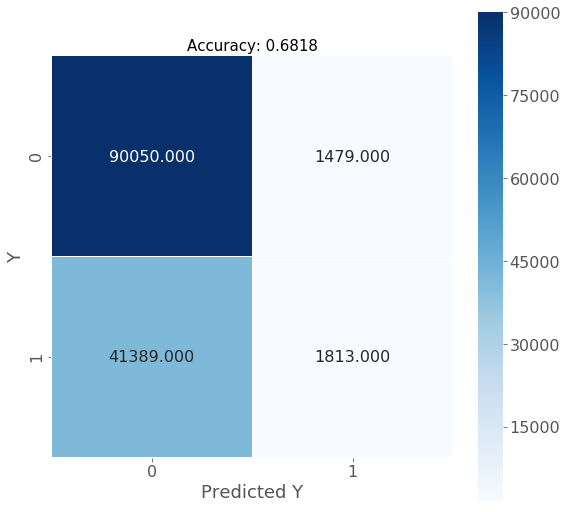

In [12]:
confusion_matrix = metrics.confusion_matrix(y_test, y_hat)
print(confusion_matrix)
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.1, square = True, cmap = 'Blues');
plt.ylabel('Y');
plt.xlabel('Predicted Y');
all_sample_title = 'Accuracy: {0:.4f}'.format(metrics.accuracy_score(y_test, y_hat))#\
# + '  Precision: {0:.4f},'.format(metrics.precision_score(y_test, y_hat))\
# + '  Recall: {0:.4f}'.format(metrics.recall_score(y_test, y_hat))
plt.title(all_sample_title, size = 15);
plt.savefig('confusion_matrix.png')

In [13]:
precision, recall, fscore, support = scores(y_test, y_hat)
array = (precision, recall, fscore, support)
columns = ['Failure', 'Succes']
index = ['Precision', 'Recall', 'F1', 'Support']
pd.DataFrame(array, index=index, columns=columns)

,Failure,Succes
Precision,0.685109,0.550729
Recall,0.983841,0.041966
F1,0.807739,0.077989
Support,91529.000000,43202.000000


In [14]:
print("Accuracy:",metrics.accuracy_score(y_test, y_hat))
print("Precision:",metrics.precision_score(y_test, y_hat))
print("Recall:",metrics.recall_score(y_test, y_hat))

Accuracy: 0.6818252666424208
Precision: 0.5507290400972054
Recall: 0.041965649738438034


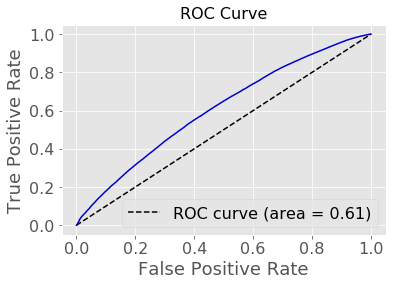

In [15]:
# Import necessary modules
from sklearn.metrics import roc_curve, auc

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logr.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.plot([0, 1], [0, 1], 'k--', label='ROC curve (area = %0.2f)' % roc_auc)
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
plt.plot(fpr, tpr, 'mediumblue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve.png')


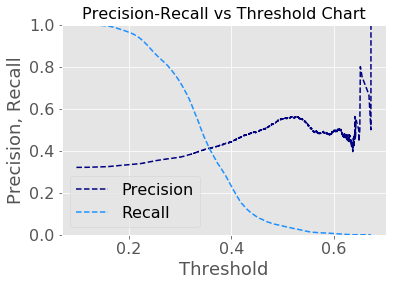

In [16]:
#Plot precision-recall curve
from sklearn.metrics import precision_recall_curve

y_pred_prob= logr.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)


roc_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "navy", linestyle='dashed', label="Precision")
plt.plot(thresholds, recall[: -1], "dodgerblue", linestyle='dashed' ,label="Recall")
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

plt.savefig('Precision-Recall_Threshold.png')

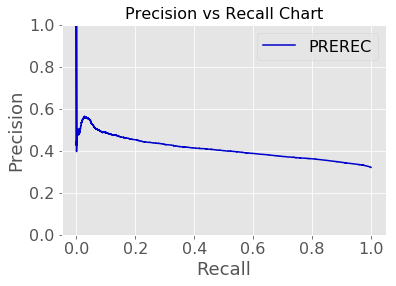

In [17]:
#Plot precision-recall curve
from sklearn.metrics import precision_recall_curve

y_pred_prob= logr.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)


roc_auc = auc(recall, precision)

plt.title("Precision vs Recall Chart")
plt.plot(recall[: -1], precision[: -1], "mediumblue", label="PREREC")
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="upper right")
plt.ylim([0,1])
plt.savefig('Precision-Recall.png')

In [18]:
auc(recall, precision)

0.40801337326275344

In [19]:
len(X.columns)


102

In [20]:
from pandas.plotting import table
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

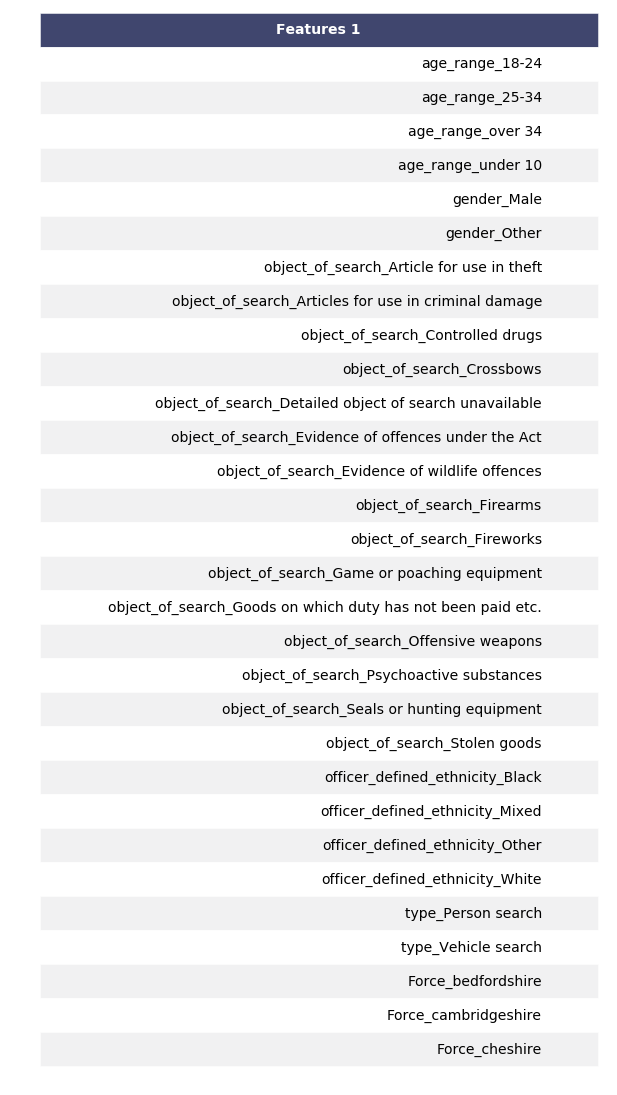

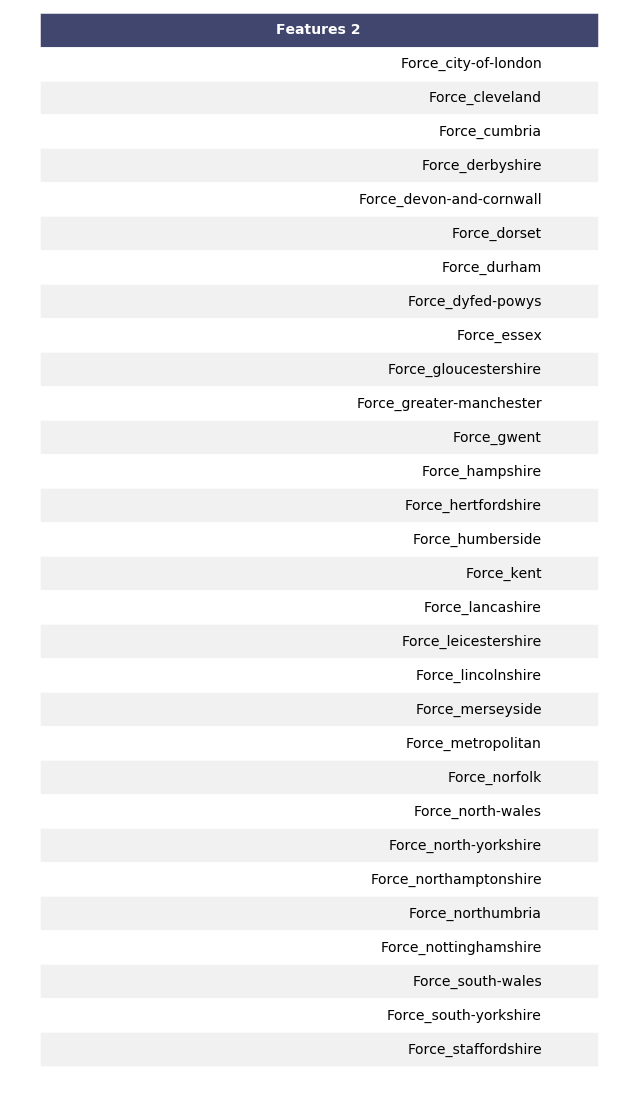

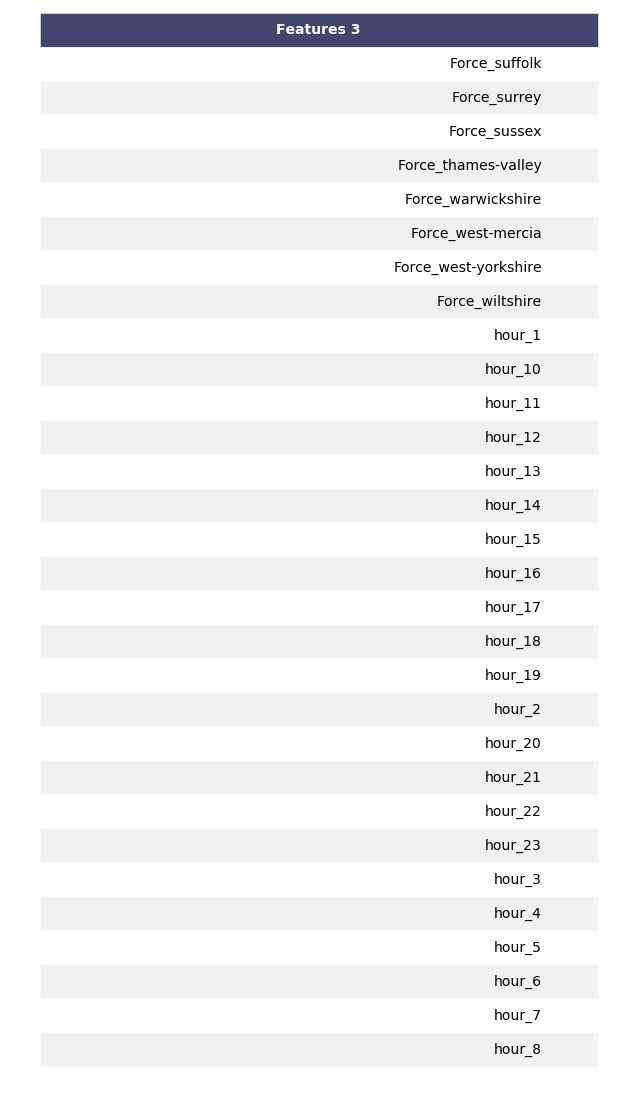

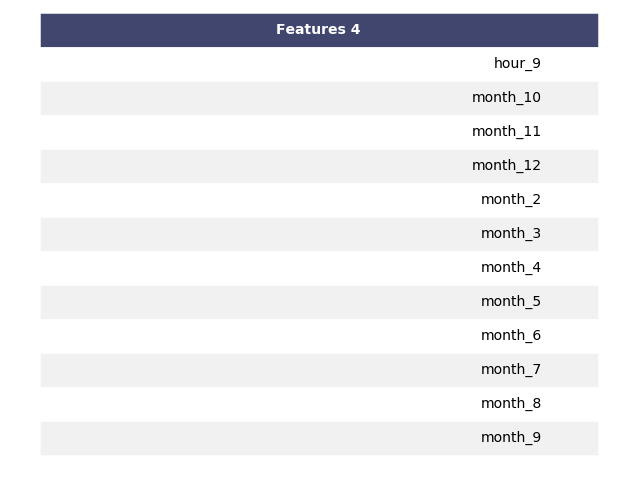

In [21]:
for i in range(0,101, 30):
    Features = pd.DataFrame(X.columns[i:(i+30)], columns=['Features '+str(i//30+1)]).reset_index(drop=True)
    render_mpl_table(Features, header_columns=0, col_width=10.0)
    plt.savefig('Features '+str(i//30+1)+'.png')